## Preprocess the data

In [5]:
# Imports

import os
import numpy as np
import cv2

In [6]:
# Constants

IMG_SIZE = 50
BASE_PATH = 'the-simpsons-characters-dataset/'
DATASET_PATH = BASE_PATH + 'simpsons_dataset/'
TESTSET_PATH = BASE_PATH + 'kaggle_simpson_testset/kaggle_simpson_testset/'

### Download TestSet (if necessary)

In [7]:
if not (os.path.isdir(BASE_PATH)):
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("alexattia/the-simpsons-characters-dataset")
    
    !!unzip the-simpsons-characters-dataset.zip -d the-simpsons-characters-dataset
    

In [8]:
LABELS = os.listdir(DATASET_PATH)

### Load Dataset

In [9]:
# Load train images and LABELS Functions

def load_data():   
    train_images = []
    train_labels = []

    for label in LABELS:
        label_folder = os.path.join(DATASET_PATH, label)
        
        if len(os.listdir(label_folder)) < 100:
            print("[WARNING]: {} has only {} images".format(label, len(os.listdir(label_folder))))
            LABELS.remove(label)
            continue
        
        for _image in os.listdir(label_folder):
            _image_path = os.path.join(label_folder, _image)
            img = cv2.imread(_image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            train_images.append(np.array(img))
            train_labels.append(LABELS.index(label))
    
    return np.array(train_images, dtype=np.float64), np.array(train_labels)

In [10]:
# Load data

train_images, train_labels = load_data()
        
print(train_images.shape)
print(LABELS)

[WARNING]: simpsons_dataset has only 42 images
[WARNING]: patty_bouvier has only 72 images
[WARNING]: rainier_wolfcastle has only 45 images
[WARNING]: martin_prince has only 71 images
[WARNING]: fat_tony has only 27 images
[WARNING]: lionel_hutz has only 3 images
[WARNING]: carl_carlson has only 98 images
[WARNING]: snake_jailbird has only 55 images
[WARNING]: sideshow_mel has only 40 images
[WARNING]: professor_john_frink has only 65 images
[WARNING]: otto_mann has only 32 images
[WARNING]: miss_hoover has only 17 images
[WARNING]: agnes_skinner has only 42 images
(15355, 50, 50)
['maggie_simpson', 'charles_montgomery_burns', 'ralph_wiggum', 'chief_wiggum', 'milhouse_van_houten', 'cletus_spuckler', 'lenny_leonard', 'sideshow_bob', 'selma_bouvier', 'barney_gumble', 'gil', 'moe_szyslak', 'edna_krabappel', 'groundskeeper_willie', 'ned_flanders', 'abraham_grampa_simpson', 'krusty_the_clown', 'waylon_smithers', 'apu_nahasapeemapetilon', 'marge_simpson', 'comic_book_guy', 'nelson_muntz', 'm

In [11]:
# Random Shuffle Train Images and LABELS (in unison)

s = np.random.permutation(len(train_labels))
np.random.shuffle(s)

train_images = train_images[s]
train_labels = train_labels[s]

### Test Loaded Dataset

In [12]:
import matplotlib.pyplot as plt

In [13]:
# Plot Image Function

def plot_img_label(img, label):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
    
def plot_img_colorbar(img):
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)


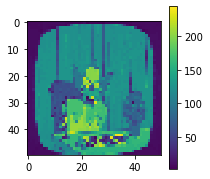

In [14]:
plt.figure(figsize = (3, 3))
plot_img_colorbar(train_images[0])
plt.show()

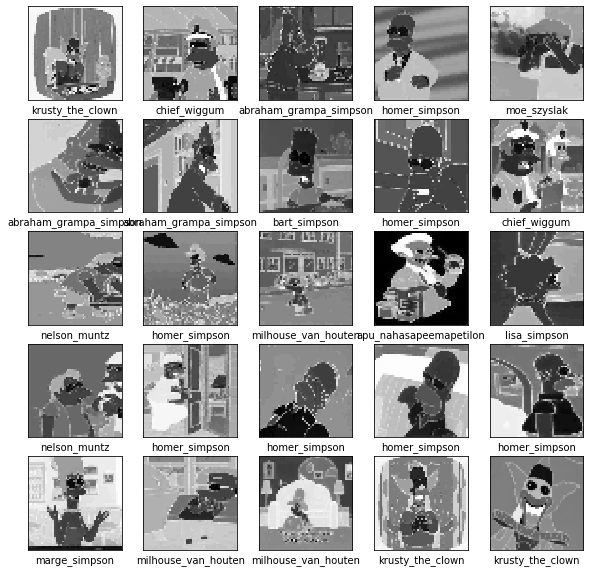

In [15]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plot_img_label(train_images[i], LABELS[train_labels[i]])
plt.show()

### Load TestSet

In [16]:

def load_testset(path):
    test_images, test_labels = [], []
    
    for _file in os.listdir(path):
        
        # get label
        label = _file.split('.')[0].split('_')[:-1]
        label = '_'.join(label)
        
        # get image
        _image_path = os.path.join(path, _file)
        img = cv2.imread(_image_path, cv2.IMREAD_GRAYSCALE)
        try:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        except:
            print("Error while resizing image")
            continue
            
        if not label in LABELS:
            print("Error - label not found")
            continue

        test_images.append(np.array(img))
        test_labels.append(LABELS.index(label))
        
    return np.array(test_images, dtype=np.float64), np.array(test_labels)

In [17]:

test_images, test_labels = load_testset(TESTSET_PATH)

print(test_images.shape)

(990, 50, 50)


## Build the model

In [18]:
# TensorFlow and tf.keras
import tensorflow
from tensorflow import keras

In [19]:
model = keras.Sequential([
    keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(LABELS), activation='softmax')
])

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [21]:
model.fit(train_images, train_labels, epochs=10)

Train on 15355 samples
Epoch 1/10
15355/15355 [==============================] - 9s 579us/sample - loss: 2.6339 - accuracy: 0.2626
Epoch 2/10
15355/15355 [==============================] - 7s 476us/sample - loss: 1.9379 - accuracy: 0.4183
Epoch 3/10
15355/15355 [==============================] - 7s 442us/sample - loss: 1.6426 - accuracy: 0.5090
Epoch 4/10
15355/15355 [==============================] - 7s 436us/sample - loss: 1.4122 - accuracy: 0.5794
Epoch 5/10
15355/15355 [==============================] - 7s 450us/sample - loss: 1.2036 - accuracy: 0.6434
Epoch 6/10
15355/15355 [==============================] - 9s 573us/sample - loss: 1.0324 - accuracy: 0.6945
Epoch 7/10
15355/15355 [==============================] - 8s 497us/sample - loss: 0.8770 - accuracy: 0.7407
Epoch 8/10
15355/15355 [==============================] - 8s 553us/sample - loss: 0.7287 - accuracy: 0.7836
Epoch 9/10
15355/15355 [==============================] - 7s 469us/sample - loss: 0.6359 - accuracy: 0.8102
Epoch

# Test the model

## Predict TestSet

In [22]:
predictions = model.predict(test_images)

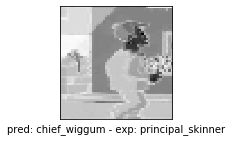

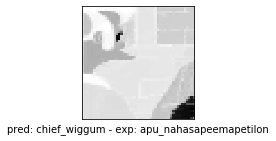

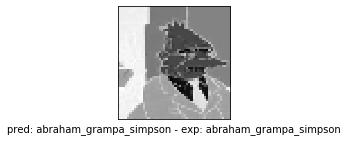

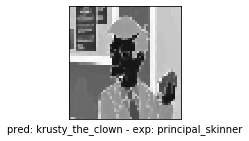

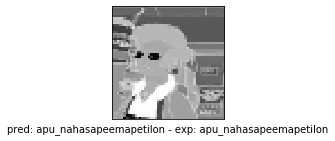

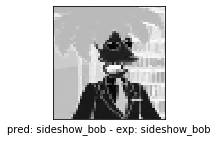

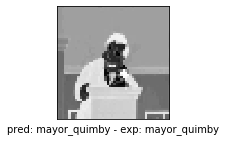

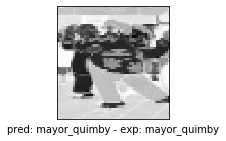

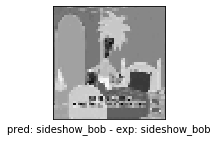

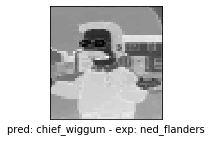

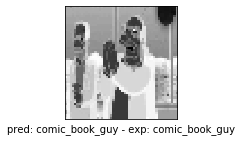

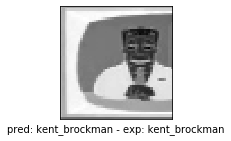

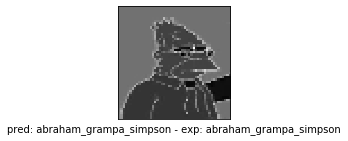

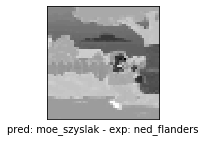

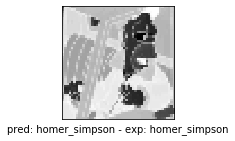

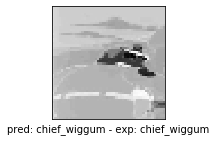

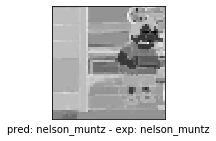

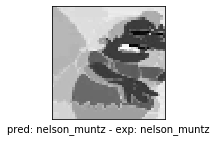

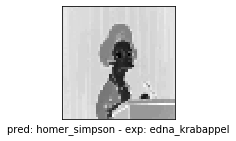

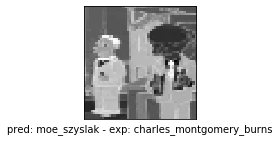

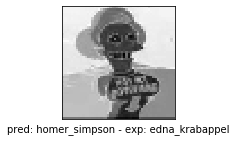

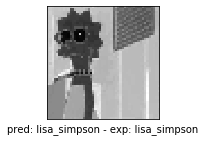

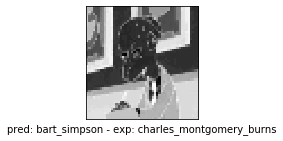

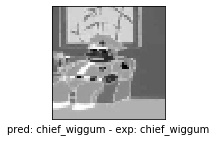

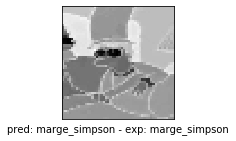

In [23]:

for i in range(25):
    pred = LABELS[np.argmax(predictions[i])]
    exp = LABELS[test_labels[i]]
    plt.figure(figsize=(12, 12))
    plot_img_label(test_images[i], "pred: {} - exp: {}".format(pred, exp))
    plt.show()

In [24]:
wrong = 0

for i in range(len(predictions)):
    pred = LABELS[np.argmax(predictions[i])]
    exp = LABELS[test_labels[i]]
    
    if pred != exp:
        wrong += 1

print("Wrong predictions -> {}".format(wrong))

print("Test accuracy -> {}".format(1 - wrong/len(predictions)))

Wrong predictions -> 378
Test accuracy -> 0.6181818181818182


## Train analisis

### Check which images had the worst results

In [116]:
# Analize errors per label

label_error = [0 for x in LABELS]

for i in range(len(predictions)):
    pred = LABELS[np.argmax(predictions[i])]
    exp = LABELS[test_labels[i]]
    
    if pred != exp:
        label_error[np.argmax(predictions[i])] += 1
        
print(label_error)

[1, 0, 0, 27, 11, 0, 0, 9, 0, 1, 0, 27, 0, 0, 0, 35, 34, 13, 13, 39, 13, 7, 6, 16, 0, 39, 34, 0, 0, 53]


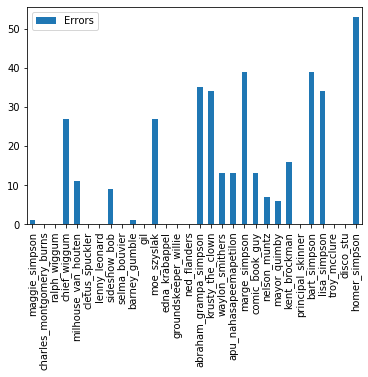

In [117]:
# Convert label_error into pandas dataframe

import pandas as pd

df = pd.DataFrame(label_error, columns=['Errors'])
df.index = LABELS

# Clear if Error is 0
df = df.replace(0, np.nan)
df.dropna()

df.plot(kind='bar')